In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
import shap

/home/tibbers/git/udacity_salaries/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Overview:</h1>
0. Business Understanding<br/>
1. Load and analyze the data<br/>
2. Preprocessing<br/>
3. Fit a simple model and evaluate it<br/>
4. Fit a more complex model and evaluate it<br/>
5. Compare the 2 models<br/>
6. Analyze for feature importance <br/>
7. Draw conclusions<br/>
8. Attendum: answer business questions more explicitly

<h2>Business Understanding</h2>
<h4>Question 1: Will obtaining a master's degree increase my salary significantly?</h4>
<h4>Question 2: Can salaries be accurately predicted from the data provided?</h4>
<h4>Question 3: Which other features are most important for predicting salaries?</h4>

<h2>1. Load and analyze the data</h2>
<h3>Gather Data</h3>

In [2]:
# load the data from the csv file
# note that it might need to be stiched together as described in the README first
survey = pd.read_csv("./survey_results_public.csv")
survey.shape

(49123, 170)

<h3>Assess Data</h3>

In [3]:
# lets see how many rows and columns we have
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49123 entries, 0 to 49122
Columns: 170 entries, ResponseId to JobSat
dtypes: float64(50), int64(1), object(119)
memory usage: 63.7+ MB


In [4]:
#since there are many object type columns, let's see how many unique values there are in each column
survey.nunique().sort_values(kind="quicksort")[150:]

AIToolPlan to partially use AI     4459
CommPlatformWantToWorkWith         4780
DevEnvsWantToWorkWith              5408
DatabaseWantToWorkWith             5474
WebframeWantToWorkWith             5726
CommPlatformHaveWorkedWith         6102
ConvertedCompYearly                6234
DatabaseHaveWorkedWith             6664
OfficeStackAsyncHaveWorkedWith     6682
WebframeHaveWorkedWith             7412
DevEnvsHaveWorkedWith              7755
LanguageAdmired                    8080
PlatformAdmired                   11025
AIExplain                         11215
PlatformWantToWorkWith            13329
LanguageWantToWorkWith            13724
LanguageHaveWorkedWith            15467
PlatformHaveWorkedWith            18782
AIOpen                            20123
ResponseId                        49123
dtype: int64

In [5]:
# drop free text columns and the ResponseId column
survey = survey.drop(survey.filter(regex='TEXT',axis=1).columns, axis=1).drop('ResponseId', axis=1)

In [6]:
# check some numeric columns
survey[['WorkExp', 'YearsCode', 'CompTotal', 'ConvertedCompYearly', 'JobSat']].describe()

,WorkExp,YearsCode,CompTotal,ConvertedCompYearly,JobSat
count,42844.000000,43000.000000,2.483900e+04,2.392800e+04,26643.000000
mean,13.370810,16.575256,2.236626e+70,1.017916e+05,7.202042
std,10.801917,11.789269,3.525011e+72,4.619345e+05,1.997234
min,1.000000,1.000000,0.000000e+00,1.000000e+00,0.000000
25%,5.000000,8.000000,5.500000e+04,3.817100e+04,6.000000
50%,10.000000,14.000000,1.050000e+05,7.538350e+04,8.000000
75%,20.000000,24.000000,2.400000e+05,1.206302e+05,8.000000
max,100.000000,100.000000,5.555556e+74,5.000000e+07,10.000000


<Axes: >

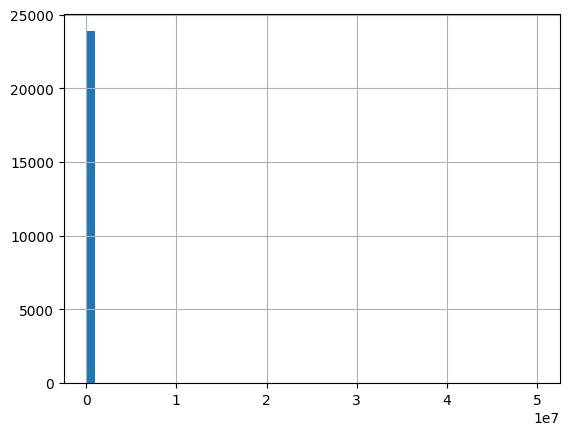

In [7]:
# lets look at the salary distribution
survey['ConvertedCompYearly'].hist(bins=50)

<h3>Cleaning Data</h3>

In [8]:
# ConvertedCompYearly will be the target variable but seems to have some outliers
# i will therefore only consider salaries below 200000 in Germany

survey = survey[survey['Country'] == 'Germany']
survey = survey[survey['ConvertedCompYearly'] <= 200000]

<Axes: >

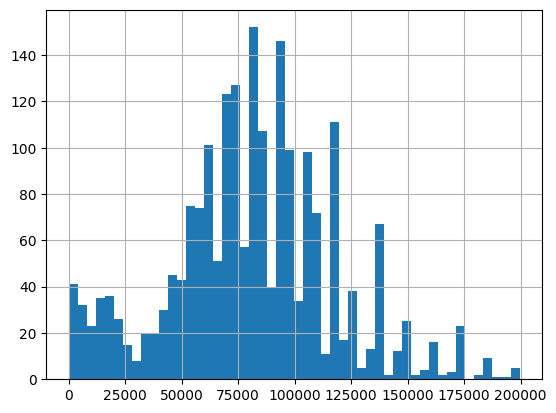

In [9]:
# much better distribution
survey['ConvertedCompYearly'].hist(bins=50)

<h3> Analyze Data</h3>

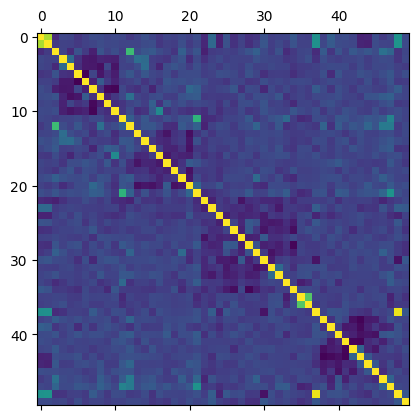

In [10]:
#plot a correlation matrix with the numeric columns
cormat = survey.select_dtypes(include='number').corr()
plt.matshow(cormat)
plt.show()

In [11]:
#This is still too many features. Lets take only the highest values
masked = cormat.mask(np.tril(np.ones(cormat.shape)).astype(np.bool))
sortpairs = masked.unstack().sort_values(kind="quicksort").reset_index()
sortpairs[0]
sortpairs[sortpairs[0].notna() & (abs(sortpairs[0])>0.2)]

# looks like ConvertedCompYearly is only correlated with work experience and coding experience

,level_0,level_1,0
0,TechEndorse_5,TechEndorse_4,-0.242753
1,SO_Actions_6,SO_Actions_1,-0.231608
2,SO_Actions_6,SO_Actions_4,-0.230968
3,TechEndorse_9,TechEndorse_6,-0.227713
4,JobSatPoints_16,JobSatPoints_9,-0.226914
5,SO_Actions_5,SO_Actions_4,-0.225233
6,TechEndorse_8,TechEndorse_6,-0.213111
7,SO_Actions_6,SO_Actions_16,-0.209247
1208,TechOppose_2,TechEndorse_2,0.203350
1209,TechOppose_1,TechEndorse_7,0.213121


In [12]:
#lets look more closely at the correlations with ConvertedCompYearly above 0.1
cormat[abs(cormat['ConvertedCompYearly']) > 0.1]['ConvertedCompYearly'].sort_values(kind="quicksort")

JobSatPoints_11       -0.179875
JobSatPoints_5        -0.115153
TechEndorse_6          0.113759
JobSatPoints_4         0.124128
WorkExp                0.390937
YearsCode              0.400234
CompTotal              0.963729
ConvertedCompYearly    1.000000
Name: ConvertedCompYearly, dtype: float64

<h2>2. Preprocessing</h2>

In [13]:
# identify and process remaining text columns
# only use categories with at least 10 occurrences
# credit of this box: GPT-5

# 1. Identify multi-choice and single-choice columns
multi_choice_cols = [
    col for col in survey.columns
    if survey[col].dropna().astype(str).str.contains(";").any()
]
single_choice_cols = [
    col for col in survey.columns
    if col not in multi_choice_cols and survey[col].dtype == "object"
]

# 2. Function to process one column with MultiLabelBinarizer
def process_multilabel_column(df, col, min_freq=2):
    '''
    returns a DataFrame with one-hot encoded columns for each category in the multi-choice column.
    Categories that appear less than min_freq times are dropped.

    input:
    df: pandas DataFrame
    col: column name (string)
    min_freq: minimum frequency to keep a category
    output: DataFrame with one-hot encoded columns
    '''
    # Split strings on ';'
    split_values = df[col].dropna().astype(str).apply(lambda x: x.split(";"))
    
    # Fit binarizer
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(split_values)
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=split_values.index)
    
    # Drop rare categories (appear < min_freq times)
    freq = encoded_df.sum(axis=0)
    keep_cols = freq[freq >= min_freq].index
    encoded_df = encoded_df[keep_cols]
    
    # Rename columns with prefix to avoid collisions
    encoded_df = encoded_df.add_prefix(f"{col}_")
    
    return encoded_df

# Function to process single-choice categorical columns
def process_singlelabel_column(df, col, min_freq=2):
    '''
    returns a DataFrame with one-hot encoded columns for each category in the single-choice column.
    Categories that appear less than min_freq times are replaced with "Other".

    input:
    df: pandas DataFrame
    col: column name (string)
    min_freq: minimum frequency to keep a category
    output: DataFrame with one-hot encoded columns
    '''

    # Count frequencies
    freq = df[col].value_counts()
    keep_values = freq[freq >= min_freq].index
    
    # Replace rare categories with "Other"
    filtered = df[col].where(df[col].isin(keep_values), "Other")
    
    # One-hot encode
    encoded_df = pd.get_dummies(filtered, prefix=col)
    
    return encoded_df


print(f"Original shape: {survey.shape}")
survey = survey.dropna(subset=["ConvertedCompYearly"]).reset_index(drop=True)
print(f"After dropping rows with missing target, shape: {survey.shape}")

# 3. Apply to all multi-choice columns
processed_dfs = []
for col in multi_choice_cols:
    processed_dfs.append(process_multilabel_column(survey, col, min_freq=10))
for col in single_choice_cols:
    processed_dfs.append(process_singlelabel_column(survey, col, min_freq=10))

# Concatenate processed features
final_features = pd.concat(processed_dfs, axis=1)


# 4. Join back with original (dropping raw multi-choice cols if desired)
survey_processed = pd.concat([survey.drop(columns=multi_choice_cols).drop(columns=single_choice_cols), final_features], axis=1)

print(f"Final processed shape: {survey_processed.shape}")

Original shape: (2099, 165)
After dropping rows with missing target, shape: (2099, 165)
Final processed shape: (2099, 1302)


In [14]:
#remove CompTotal and ConvertedCompYearly as well as JobSatPoints_11 (Competitive pay and benefits) from the feature set and define the target variable
X=survey_processed.drop(['CompTotal','ConvertedCompYearly','JobSatPoints_11'],axis=1)
y=survey_processed['ConvertedCompYearly']
print(X.shape,y.shape)

(2099, 1299) (2099,)


In [15]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1574, 1299) (525, 1299) (1574,) (525,)


<h2>2. Fit a simple model and evaluate it</h2>

In [16]:
# DecisionTreeRegressor does not handle missing values, so we will fill them with the mean of the respective columns
# dropping these rows would result in a significantly lower number of training examples which i want to avoid since many columns have missing values and i alredy reduced the dataset significantly by filtering for germany and excluding high salaries
# therefore i will use mean imputation here which may result distort the distribution of some features but should be acceptable for this simple model, as the goal is to get a first benchmark
X_train_simple = X_train.fillna(X_train.mean())
X_test_simple = X_test.fillna(X_test.mean())

In [17]:
simple_model = DecisionTreeRegressor(max_depth=3, random_state=42)
simple_model.fit(X_train_simple, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [18]:
y_pred_train_simple= simple_model.predict(X_train_simple)
print('train rmse',root_mean_squared_error(y_pred_train_simple,y_train))
y_pred_simple = simple_model.predict(X_test_simple)
print('test rmse',root_mean_squared_error(y_pred_simple,y_test))
print('test r2',r2_score(y_test,y_pred_simple))

train rmse 30518.08451575434
test rmse 29971.832902227943
test r2 0.30510802580171514


<h2>3. Fit a more complex model and evaluate it</h2>

In [19]:
complex_model = HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=0.05, max_depth=3, max_iter=200, min_samples_leaf=20, random_state=42)
complex_model.fit(X_train,y_train)

,loss,'squared_error'
,quantile,None
,learning_rate,0.05
,max_iter,200
,max_leaf_nodes,31
,max_depth,3
,min_samples_leaf,20
,l2_regularization,1.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [20]:
y_pred_train_complex= complex_model.predict(X_train)
print('train rmse',root_mean_squared_error(y_pred_train_complex,y_train))
y_pred_complex= complex_model.predict(X_test)
print('test rmse',root_mean_squared_error(y_pred_complex,y_test))
print('test r2',r2_score(y_test,y_pred_complex))

train rmse 20475.523220128416
test rmse 25864.688303334893
test r2 0.4825061552239963


<h2>4. Compare the 2 models</h2>
The complex model performs significantly better overall compared to the simple model. The RMSE is lower and the R2 score is higher.

<h2>5. Analyze for feature importance </h2>

In [21]:
# use the shap library to analyze feature importance

# Convert boolean columns to int for SHAP compatibility
X_train_shap = X_train.copy()
for col in X_train_shap.select_dtypes(include='bool').columns:
	X_train_shap[col] = X_train_shap[col].astype(int)

x100 = shap.utils.sample(X_train_shap, 100, random_state=42)
explainer = shap.Explainer(complex_model, x100)
shap_values = explainer(X_train_shap)

<h3>Visualize Feature Importance</h3>

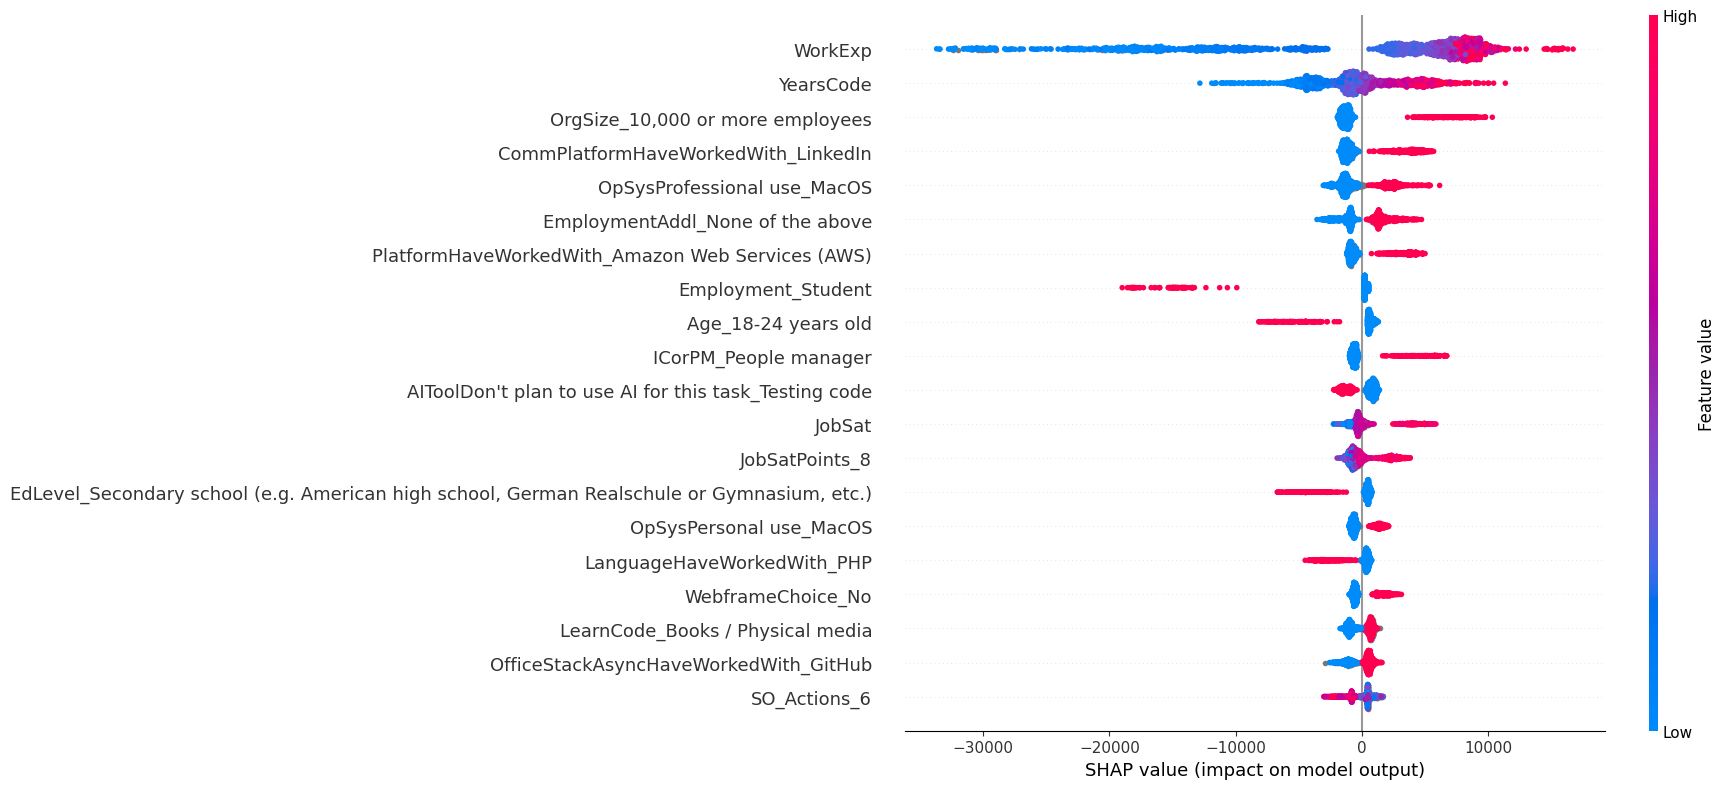

In [22]:
shap.summary_plot(shap_values, X_train_shap, plot_size=[18,8])

Work experience, organization size and tools used seem to be the most important features in predicting salary.

<h2> Draw conclusions </h2>
Overall, the complex model is better at predicting salaries than the simple model. <br/>
However, predicting salaries is inherently difficult due to the many factors that influence salary that are not captured in the data set, such as soft skills including negotiation skills.

<h2>Attendum: answer business questions more explicitly</h2>
<h3>Question 1: Will obtaining a master's degree increase my salary significantly?</h3>

In [23]:
# Lets see how much of the variance can be explaind by education level alone
X_1 = X.filter(regex='EdLevel',axis=1)
y_1 = y
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=42)
complex_model_1 = HistGradientBoostingRegressor(random_state=42)
complex_model_1.fit(X_train_1, y_train_1)
y_pred_1 = complex_model_1.predict(X_test_1)
r2_1 = r2_score(y_test_1, y_pred_1)
print(f"R2: {r2_1}")

R2: 0.06964832040032765


In [24]:
# show the rank of the education level features in the overall feature importance
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False).reset_index(drop=True)
feature_importance[feature_importance['col_name'].str.contains('EdLevel')]

,col_name,feature_importance_vals
13,EdLevel_Secondary school (e.g. American high s...,879.651065
42,"EdLevel_Master’s degree (M.A., M.S., M.Eng., M...",346.877878
43,EdLevel_Some college/university study without ...,329.405648
74,"EdLevel_Associate degree (A.A., A.S., etc.)",190.891825
87,"EdLevel_Professional degree (JD, MD, Ph.D, Ed....",153.112732
202,"EdLevel_Bachelor’s degree (B.A., B.S., B.Eng.,...",34.259878
658,EdLevel_Other (please specify):,0.000000
659,EdLevel_Other,0.000000


Only 7% of the variance can be explained by education level alone.<br/>
Not obtaining any degree has feature rank 13, while the master's degree rank is just 42.

In [25]:
X.filter(regex='EdLevel',axis=1).columns
mdsal = survey_processed[survey_processed['EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)']==1]['ConvertedCompYearly']
bdsal = survey_processed[survey_processed['EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)']==1]['ConvertedCompYearly']
print(f"Average salary for master's degree holders: {mdsal.mean():.2f} EUR")
print(f"Average salary for bachelor's degree holders: {bdsal.mean():.2f} EUR")
print(f"standard deviation in salary for master's degree holders: {mdsal.std():.2f} EUR")
print(f"standard deviation in salary for bachelor's degree holders: {bdsal.std():.2f} EUR")

Average salary for master's degree holders: 90878.52 EUR
Average salary for bachelor's degree holders: 80564.32 EUR
standard deviation in salary for master's degree holders: 33447.25 EUR
standard deviation in salary for bachelor's degree holders: 35732.29 EUR


Using standard methods we find that the average salary for a master's degree holder is about 10k higher than for a bachelor's degree holder.<br/>
Indicating that a master's degree does have a positive effect on salary, but the effect is not very large compared to the overall variance in salaries.
<h3>Question 2: Can salaries be accurately predicted from the data provided?</h3>
The complex model achieves an R2 score of about 0.48, meaning that it can explain about 48% of the variance in salaries.<br/>
This is a moderate result, indicating that while the model can capture some of the factors influencing salary, there are still many other factors not included in the data set that affect salary.
<h3>Question 3: Which other features are most important for predicting salaries?</h3>
As seen in the feature importance plot,
work experience, organization size and tools used seem to be the most important features in predicting salary.
